
Unique CoC Names in clean_age_df after cleaning:
['Santa Clara' 'San Francisco' 'Alameda' 'Sacramento' 'Sonoma'
 'Contra Costa' 'Monterey' 'San Benito' 'Marin' 'Santa Cruz' 'Mendocino'
 'Stanislaus' 'San Joaquin' 'San Mateo' 'Kings' 'Tulare' 'Fresno' 'Madera'
 'Placer' 'Shasta' 'Siskiyou' 'Lassen' 'Plumas' 'Del Norte' 'Modoc'
 'Sierra' 'Napa' 'Solano' 'Butte' 'Merced' 'Yolo' 'Humboldt' 'Colusa'
 'Glenn' 'Trinity' 'El Dorado' 'Amador' 'Calaveras' 'Mariposa' 'Tuolumne'
 'Tehama' 'Lake' 'Alpine' 'Inyo' 'Mono' 'Nevada' 'Los Angeles' 'San Diego'
 'Orange' 'Santa Barbara' 'Kern' 'Riverside' 'San Bernardino' 'Ventura'
 'Imperial' 'San Luis Obispo' 'Yuba' 'Sutter']

Unique values under 'Name' in weather_df:
['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa'
 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo'
 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera' 'Marin' 'Mariposa'
 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange'

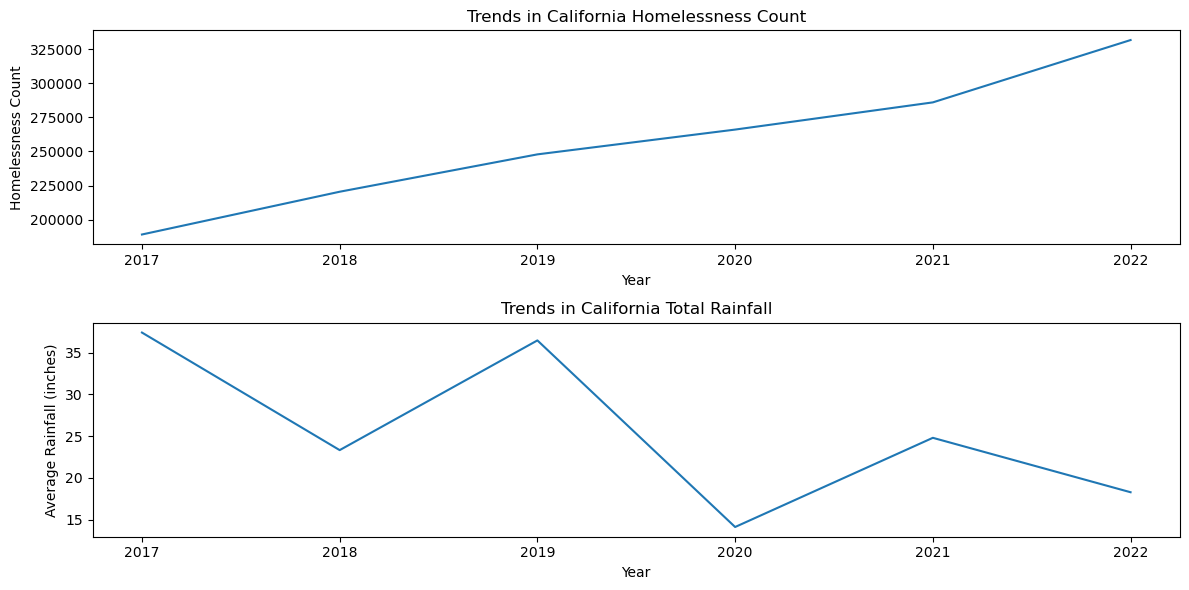

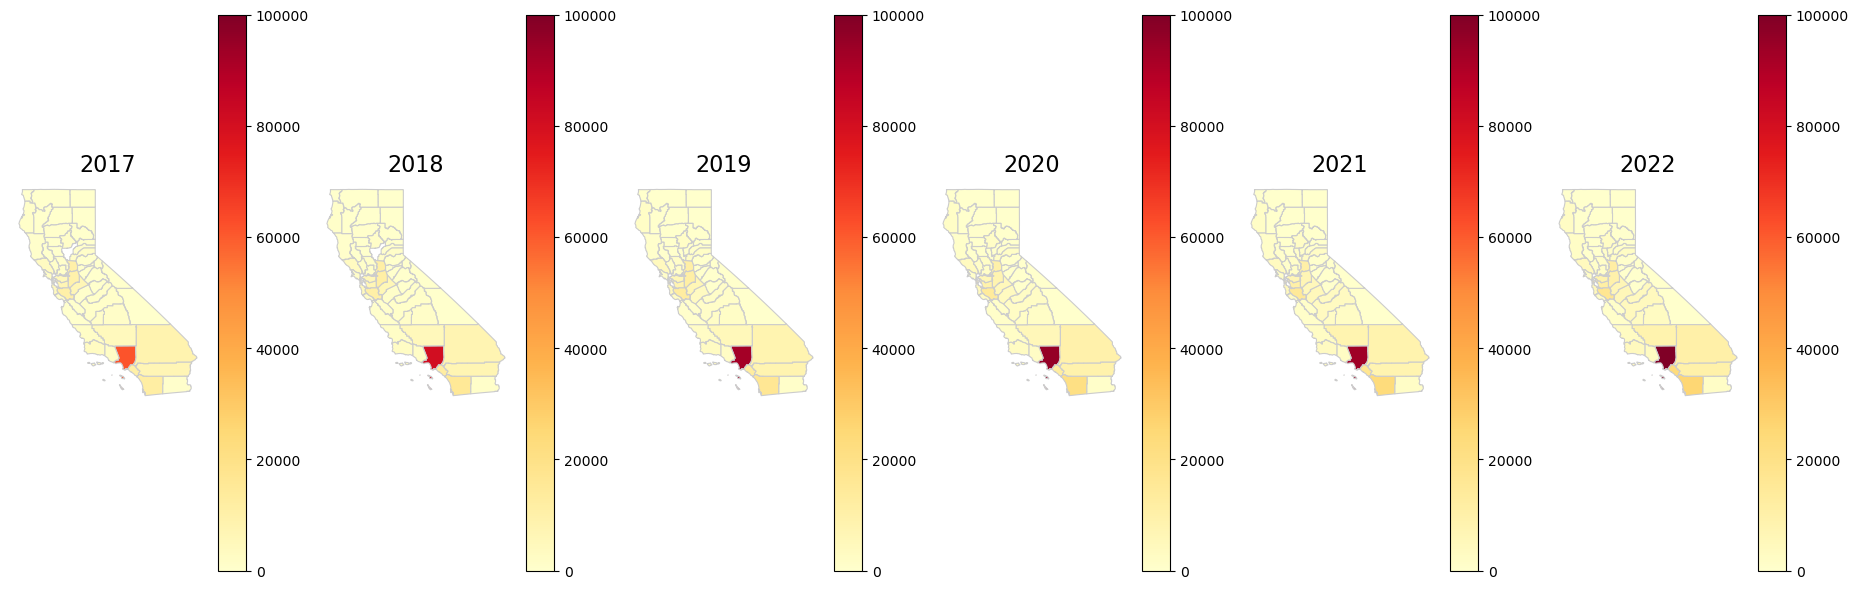

In [26]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Read weather data
weather_data = Path('resourcesJohn/20172022precipitation.csv')
weather_df = pd.read_csv(weather_data)

# Clean and calculate sum of rainfall for each year
weather_df['Year'] = pd.to_datetime(weather_df['Year'], format='%Y')
weather_df['RainfallInInches'] = pd.to_numeric(weather_df['Value'], errors='coerce')
total_rainfall_per_year = weather_df.groupby(weather_df['Year'].dt.year)['RainfallInInches'].mean()

# Read age data
age_data = Path('resourcesJohn/experiencing_homelessness_age_demographics.csv')
age_df = pd.read_csv(age_data)

# Clean age data
clean_age_df = age_df.loc[age_df['EXPERIENCING_HOMELESSNESS_CNT'] != '*'].copy()
clean_age_df['EXPERIENCING_HOMELESSNESS_CNT'] = clean_age_df['EXPERIENCING_HOMELESSNESS_CNT'].astype(int)
clean_age_df['CALENDAR_YEAR'] = pd.to_datetime(clean_age_df['CALENDAR_YEAR'], format='%Y')

# Clean and standardize county names in clean_age_df and weather_df
clean_age_df['COC_NAME'] = clean_age_df['COC_NAME'].str.lower().str.strip().str.replace(' county coc', '')
clean_age_df['COC_NAME'] = clean_age_df['COC_NAME'].str.replace('san francisco coc', 'san francisco')

# Group any names containing "los angeles county" to just "los angeles"
clean_age_df.loc[clean_age_df['COC_NAME'].str.contains('los angeles county'), 'COC_NAME'] = 'los angeles'

# Filter out rows with CoC Name "california"
clean_age_df = clean_age_df[clean_age_df['COC_NAME'] != 'california']

# Remove "counties coc" from CoC names ending with it
clean_age_df.loc[:, 'COC_NAME'] = clean_age_df['COC_NAME'].str.replace(' counties coc', '')

# Capitalize the first letter of all words in "COC_NAME" field in clean_age_df
clean_age_df.loc[:, 'COC_NAME'] = clean_age_df['COC_NAME'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

# Function to split CoC names and divide homeless counts
def split_coc_and_divide_counts(row):
    coc_name = row['COC_NAME']
    counties = coc_name.split(', ')
    num_counties = len(counties)
    homeless_count = row['EXPERIENCING_HOMELESSNESS_CNT']
    divided_count = homeless_count / num_counties
    
    data = {'CALENDAR_YEAR': row['CALENDAR_YEAR'], 'COC_NAME': counties, 'EXPERIENCING_HOMELESSNESS_CNT': divided_count}
    return pd.DataFrame(data)

# Split CoC names and divide homeless counts
clean_age_df = pd.concat(clean_age_df.apply(split_coc_and_divide_counts, axis=1).tolist(), ignore_index=True)

# Capitalize the first letter of all words in "Name" field in weather_df and remove " County" from the end
weather_df['Name'] = weather_df['Name'].str.lower().str.strip().str.replace(' county', '').apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

# Get a list of all unique CoC Name values in clean_age_df after cleaning
unique_coc_names = clean_age_df['COC_NAME'].unique()
print("\nUnique CoC Names in clean_age_df after cleaning:")
print(unique_coc_names)

# Get a list of all unique values under the "Name" column in weather_df
unique_weather_names = weather_df['Name'].unique()
print("\nUnique values under 'Name' in weather_df:")
print(unique_weather_names)

# Group by year and sum homeless counts
total_homeless_count = clean_age_df.groupby(clean_age_df['CALENDAR_YEAR'].dt.year)['EXPERIENCING_HOMELESSNESS_CNT'].sum()

# Plot trends in homelessness count and total rainfall for each year
plt.figure(figsize=(12, 6))

# Plot 1: Homelessness Count
plt.subplot(2, 1, 1)
plt.plot(total_homeless_count.index, total_homeless_count.values)
plt.xlabel('Year')
plt.ylabel('Homelessness Count')
plt.title('Trends in California Homelessness Count')

# Plot 2: Total Rainfall
plt.subplot(2, 1, 2)
plt.plot(total_rainfall_per_year.index, total_rainfall_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Rainfall (inches)')
plt.title('Trends in California Total Rainfall')

plt.tight_layout()
plt.show()



# Function to create the choropleth map for a specific year
def create_choropleth_map(year, ax):
    # Sum the homeless count grouped by year and county (CoC Name)
    clean_age_df_grouped = clean_age_df.groupby(['CALENDAR_YEAR', 'COC_NAME'], as_index=False)['EXPERIENCING_HOMELESSNESS_CNT'].sum()

    # Capitalize the first letter of all words in "COC_NAME" field in clean_age_df
    clean_age_df_grouped['COC_NAME'] = clean_age_df_grouped['COC_NAME'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

    # Filter data for the specific year
    clean_age_df_filtered = clean_age_df_grouped[clean_age_df_grouped['CALENDAR_YEAR'].dt.year == year]

    # Merge homeless counts with California county boundaries data (same as before)
    california_counties = gpd.read_file('california_counties.geojson')

    # Capitalize the first letter of all words in "name" field in california_counties
    california_counties['name'] = california_counties['name'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

    # Merge data with county boundaries
    merged_df = pd.merge(california_counties, clean_age_df_filtered, left_on='name', right_on='COC_NAME', how='left')

    # Plot the choropleth map with fixed range for legend
    mappable = merged_df.plot(column='EXPERIENCING_HOMELESSNESS_CNT', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, vmin=0, vmax=100000, ax=ax)

    # Update the title and place the Year number below "Homeless Count by County"
    ax.set_title(f'Homeless Count by County\nYear - {year}', pad=20)

    ax.set_axis_off()
    return mappable  # Return the mappable object


# Create choropleth maps for each year
years = [2017, 2018, 2019, 2020, 2021, 2022]
fig, axs = plt.subplots(1, len(years), figsize=(20, 6), sharey=True)
mappables = []  # List to store the mappable objects for colorbar

for i, year in enumerate(years):
    mappable = create_choropleth_map(year, axs[i])
    mappables.append(mappable)
    axs[i].set_title(str(year), fontsize=16)  # Set title to just the year

# Position the legend outside the plot area
plt.tight_layout()

# Create a single colorbar for all maps
fig.subplots_adjust(right=0.9)
#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar = fig.colorbar(mappables[0].get_children()[0], cax=cbar_ax)
#cbar.set_label('Homeless Count by County', fontsize=14)  # Set the colorbar label

plt.show()

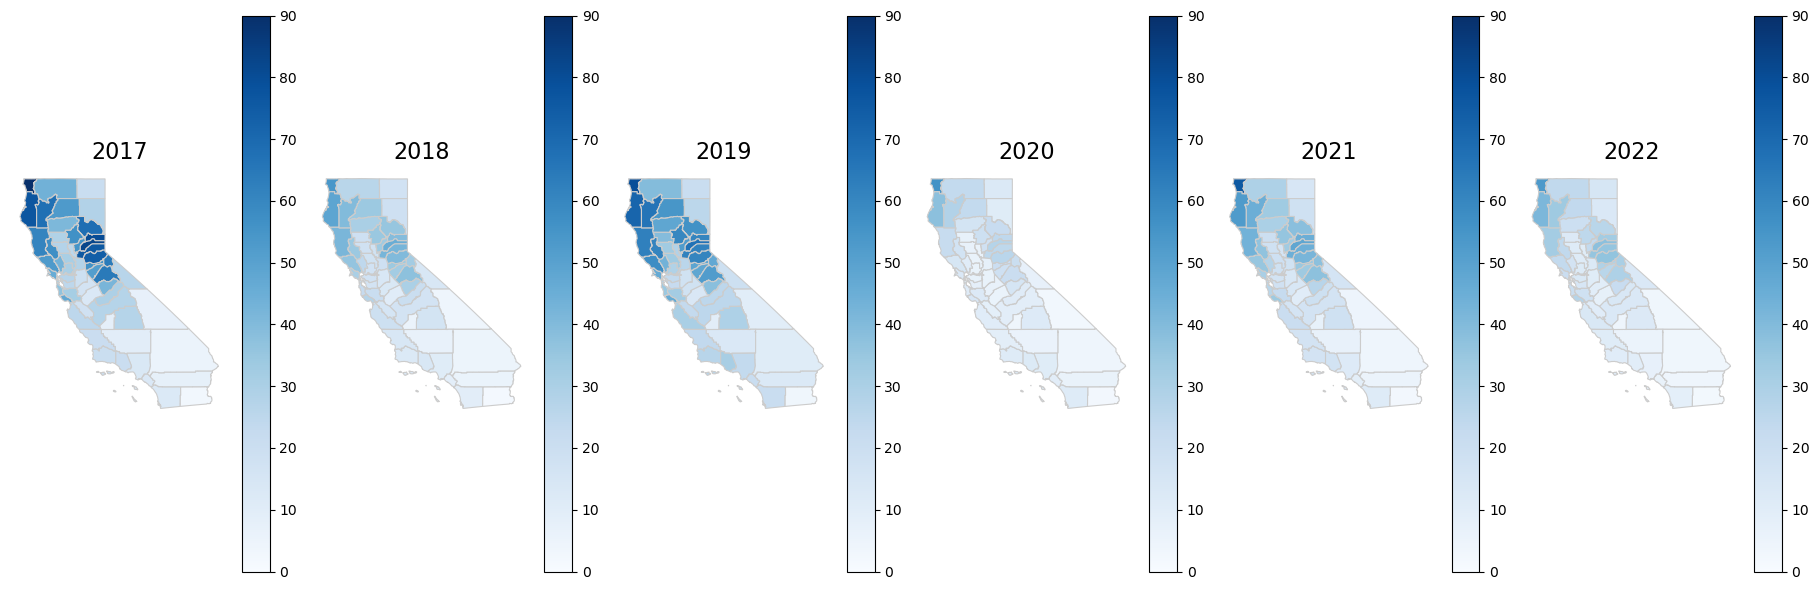

In [28]:
def create_precipitation_choropleth(year, ax):
    # Filter weather data for the specific year
    weather_df_filtered = weather_df[weather_df['Year'].dt.year == year]

    # Group weather data by county and calculate average precipitation
    avg_precip_by_county = weather_df_filtered.groupby('Name')['RainfallInInches'].mean().reset_index()

    # Merge average precipitation data with California county boundaries data
    california_counties = gpd.read_file('california_counties.geojson')
    merged_df = pd.merge(california_counties, avg_precip_by_county, left_on='name', right_on='Name', how='left')

    # Plot the choropleth map with fixed range for legend
    mappable = merged_df.plot(column='RainfallInInches', cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True, vmin=0, vmax=90, ax=ax)

    # Update the title and place the Year number below "Precipitation by County"
    ax.set_title(f'Precipitation by County\nYear - {year}', pad=20)

    # Remove boxes with tick marks
    ax.set_axis_off()

    return mappable  # Return the mappable object


# Create precipitation choropleth maps for each year
years = [2017, 2018, 2019, 2020, 2021, 2022]
fig, axs = plt.subplots(1, len(years), figsize=(20, 6), sharey=True)
mappables_precip = []  # List to store the mappable objects for precipitation colorbar

for i, year in enumerate(years):
    mappable_precip = create_precipitation_choropleth(year, axs[i])
    mappables_precip.append(mappable_precip)
    axs[i].set_title(f'Homeless Count by County\nYear - {year}', fontsize=16)  # Set title to just the year for homeless count
    axs[i].set_title(str(year), fontsize=16)  # Set title to just the year for precipitation

# Position the legend outside the plot area
plt.tight_layout()

# Create a single colorbar for precipitation
fig.subplots_adjust(right=0.9)
#cbar_ax_precip = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_precip = fig.colorbar(mappables_precip[0].get_children()[0], cax=cbar_ax_precip)
#cbar_precip.set_label('Average Precipitation (inches)', fontsize=14)  # Set the precipitation colorbar label

# Show the plots
plt.show()

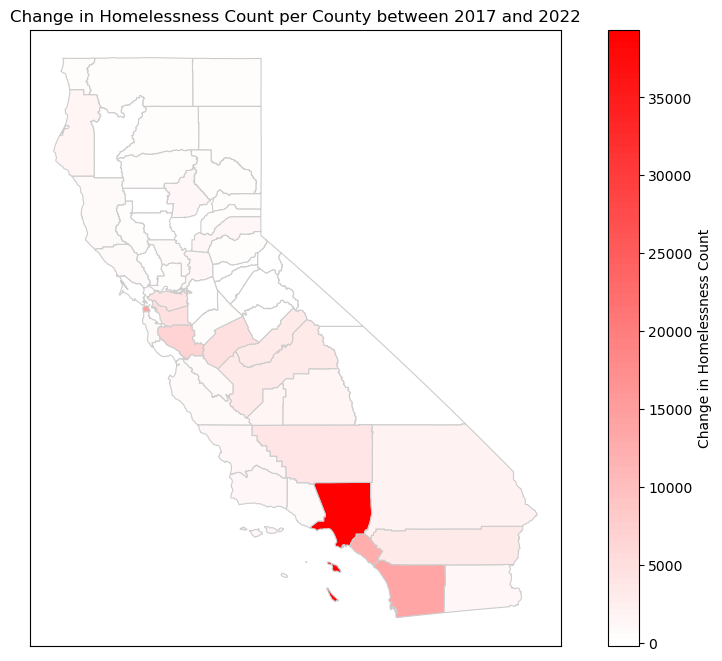


Counties ordered by the largest change in homelessness count between 2017 and 2022:
CALENDAR_YEAR           County   Change
0                  Los Angeles  39349.0
1                San Francisco  14392.0
2                    San Diego  13889.0
3                       Orange  12635.0
4                  Santa Clara   6803.0
5                      Alameda   4915.0
6                       Merced   4870.0
7                         Kern   4059.0
8                 Contra Costa   3853.0
9                    Riverside   3358.0
10                      Madera   3174.0
11                      Fresno   3174.0
12              San Bernardino   1981.0
13                    Humboldt   1606.0
14                      Tulare   1568.0
15                       Kings   1568.0
16                    Imperial   1361.0
17                  Sacramento   1308.0
18                      Placer   1238.0
19                       Butte   1201.0
20             San Luis Obispo   1168.0
21               Santa Barbara   10

In [27]:

# Step 1: Calculate the change and percentage change for homelessness count
# Homelessness Count
homelessness_change_df = clean_age_df.pivot_table(index='COC_NAME', columns=clean_age_df['CALENDAR_YEAR'].dt.year, values='EXPERIENCING_HOMELESSNESS_CNT', aggfunc='sum')
homelessness_change_df['Change'] = homelessness_change_df[2022] - homelessness_change_df[2017]
homelessness_change_df['PercentageChange'] = (homelessness_change_df['Change'] / homelessness_change_df[2017]) * 100

# Step 2: Sort the dataframes based on the largest change
# Homelessness Count
homelessness_change_df_sorted = homelessness_change_df.sort_values(by='Change', ascending=False)

# Step 3: Create the new dataframe for plotting
# Homelessness Count
homelessness_change_df_sorted = homelessness_change_df_sorted.reset_index()
homelessness_change_df_sorted = homelessness_change_df_sorted[['COC_NAME', 'Change', 'PercentageChange']]
homelessness_change_df_sorted = homelessness_change_df_sorted.rename(columns={'COC_NAME': 'County'})

# Load the GeoJSON file for California counties
california_counties = gpd.read_file('california_counties.geojson')

# Merge county boundaries data with the sorted homelessness change data
merged_df = pd.merge(california_counties, homelessness_change_df_sorted, left_on='name', right_on='County', how='left')

# Create the figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define a custom colormap that ranges from white to red
colors = ['white', 'red']
cmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', colors, N=100)

# Plot the choropleth map using the 'Change' field for coloring
vmin = -200.0  # Change this to the desired lower bound (e.g., -200.0)
vmax = 39349.0  # Change this to the desired upper bound (e.g., 39349.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
im = merged_df.plot(column='Change', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Change in Homelessness Count')

# Set the title for the plot
plt.title('Change in Homelessness Count per County between 2017 and 2022')

# Remove x and y axis ticks and labels for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

# Round the "Change" values to the whole number
homelessness_change_df_sorted['Change'] = homelessness_change_df_sorted['Change'].round(0)

# Display the entire table for "Counties ordered by the largest change in homelessness count between 2017 and 2022"
pd.set_option('display.max_rows', None)
print("\nCounties ordered by the largest change in homelessness count between 2017 and 2022:")
print(homelessness_change_df_sorted[['County', 'Change']].reset_index(drop=True))

california_counties columns: Index(['name', 'cartodb_id', 'created_at', 'updated_at', 'geometry'], dtype='object')
homelessness_change_df_sorted columns: Index(['County', 'Change', 'PercentageChange'], dtype='object', name='CALENDAR_YEAR')


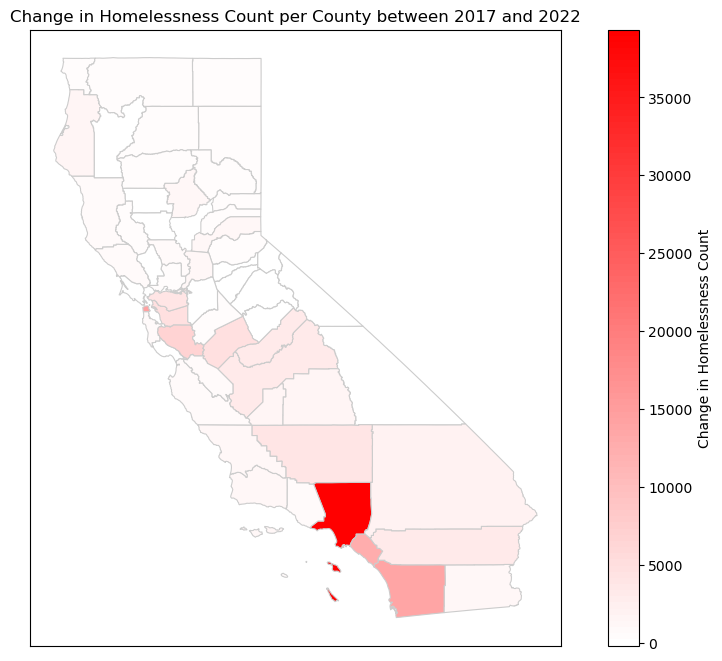

In [7]:
# Load the GeoJSON file for California counties
california_counties = gpd.read_file('california_counties.geojson')

# Print column names for california_counties
print("california_counties columns:", california_counties.columns)

# Print column names for homelessness_change_df_sorted
print("homelessness_change_df_sorted columns:", homelessness_change_df_sorted.columns)

# Merge county boundaries data with the sorted homelessness change data
merged_df = pd.merge(california_counties, homelessness_change_df_sorted, left_on='name', right_on='County', how='left')

# Create the figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define a custom colormap that ranges from white to red
colors = ['white', 'red']
cmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', colors, N=100)

# Plot the choropleth map using the 'Change' field for coloring
vmin = merged_df['Change'].min()
vmax = merged_df['Change'].max()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
im = merged_df.plot(column='Change', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Change in Homelessness Count')

# Set the title for the plot
plt.title('Change in Homelessness Count per County between 2017 and 2022')

# Remove x and y axis ticks and labels for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

In [8]:
# Display the first few rows of homelessness_change_df_sorted to find the correct column name
print(homelessness_change_df_sorted.head())

CALENDAR_YEAR         County   Change  PercentageChange
0                Los Angeles  39349.0         64.060236
1              San Francisco  14392.0        324.071155
2                  San Diego  13889.0        118.385612
3                     Orange  12635.0        119.310670
4                Santa Clara   6803.0         65.895002


In [9]:
# Load the weather data
weather_df = pd.read_csv('resourcesJohn/20172022averageweather.csv')

# Clean the "Name" column by removing " County" from all rows
weather_df['Name'] = weather_df['Name'].str.replace(' County', '')

# Group weather data by county and calculate average weather value
avg_weather_by_county = weather_df.groupby(['Name', 'Year'])['Value'].mean().reset_index()

# Display the first few rows of the average weather data
print(avg_weather_by_county.head())

      Name  Year  Value
0  Alameda  2017   60.5
1  Alameda  2018   59.8
2  Alameda  2019   59.7
3  Alameda  2020   61.7
4  Alameda  2021   60.4


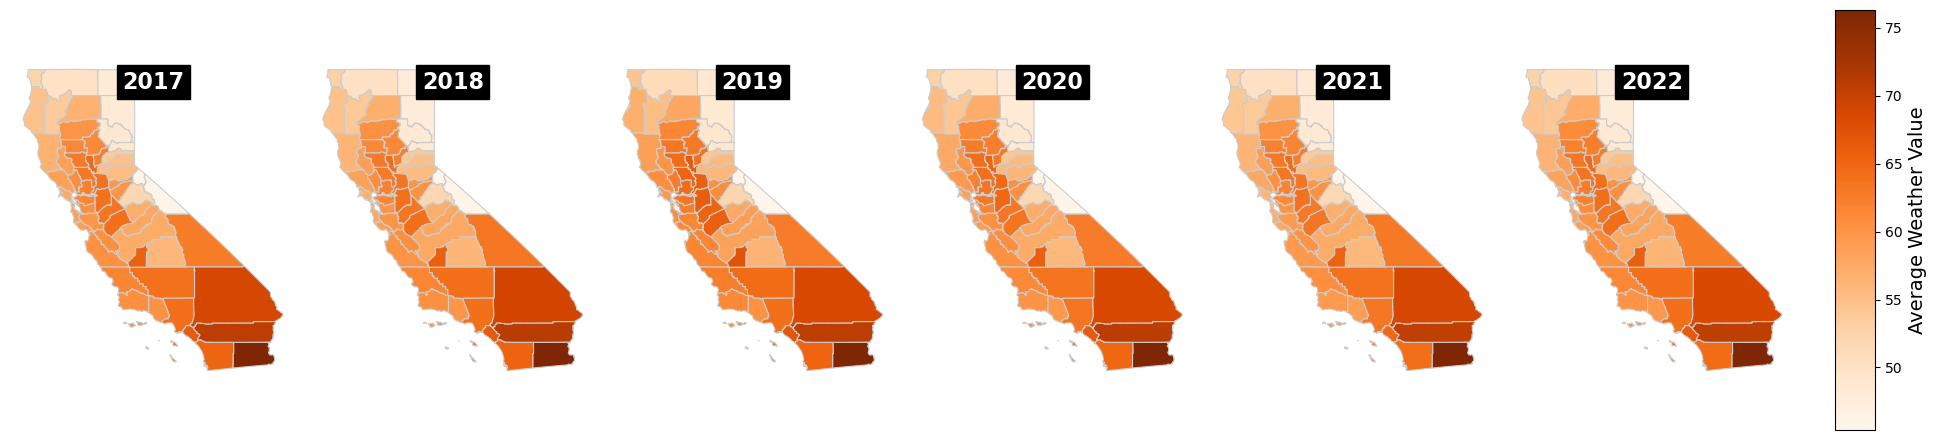

In [10]:
def create_weather_choropleth(year, ax):
    # Filter average weather data for the specific year
    weather_df_filtered = avg_weather_by_county[avg_weather_by_county['Year'] == year]

    # Merge average weather data with California county boundaries data
    california_counties = gpd.read_file('california_counties.geojson')
    merged_df = pd.merge(california_counties, weather_df_filtered, left_on='name', right_on='Name', how='left')

    # Plot the choropleth map with dynamic range for legend
    mappable = merged_df.plot(column='Value', cmap='Oranges', linewidth=0.8, edgecolor='0.8', legend=False, ax=ax)

    # Add the year number label to the map
    ax.text(0.5, 0.95, str(year), transform=ax.transAxes, fontsize=16, ha='center', va='top', fontweight='bold', color='white', backgroundcolor='black')

    # Remove boxes with tick marks and axis
    ax.set_axis_off()

    return mappable  # Return the mappable object


# Create weather choropleth maps for each year
years = [2017, 2018, 2019, 2020, 2021, 2022]
fig, axs = plt.subplots(1, len(years), figsize=(20, 6), sharey=True)
mappables_weather = []  # List to store the mappable objects for weather colorbar

for i, year in enumerate(years):
    mappable_weather = create_weather_choropleth(year, axs[i])
    mappables_weather.append(mappable_weather)

# Position the legend outside the plot area
plt.tight_layout()

# Create a single colorbar for weather
fig.subplots_adjust(right=0.9)
cbar_ax_weather = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_weather = fig.colorbar(mappables_weather[0].get_children()[0], cax=cbar_ax_weather)
cbar_weather.set_label('Average Weather Value', fontsize=14)  # Set the weather colorbar label

# Show the plots
plt.show()

In [11]:
# Calculate the change in average weather per county between 2017 and 2022
avg_weather_change_df = avg_weather_by_county.pivot_table(index='Name', columns='Year', values='Value', aggfunc='mean')
avg_weather_change_df['Change'] = avg_weather_change_df[2022] - avg_weather_change_df[2017]

# Sort the data based on the largest change
avg_weather_change_df_sorted = avg_weather_change_df.sort_values(by='Change', ascending=False)

# Create the new dataframe for plotting
avg_weather_change_df_sorted.reset_index(inplace=True)
avg_weather_change_df_sorted = avg_weather_change_df_sorted[['Name', 'Change']]
avg_weather_change_df_sorted.rename(columns={'Name': 'County'}, inplace=True)

# Display the entire table
pd.set_option('display.max_rows', None)
print("\nCounties ordered by the largest change in average weather between 2017 and 2022:")
print(avg_weather_change_df_sorted.reset_index(drop=True))


Counties ordered by the largest change in average weather between 2017 and 2022:
Year           County  Change
0               Butte     1.0
1              Tehama     0.6
2            Siskiyou     0.6
3              Amador     0.5
4               Glenn     0.5
5           El Dorado     0.4
6              Shasta     0.4
7             Trinity     0.4
8              Alpine     0.3
9           Calaveras     0.3
10               Yuba     0.2
11             Placer     0.2
12             Fresno     0.2
13             Madera     0.2
14       Contra Costa     0.2
15           Mariposa     0.2
16             Tulare     0.1
17               Yolo     0.1
18            Alameda     0.1
19             Solano     0.1
20         San Benito     0.1
21              Modoc     0.1
22             Nevada     0.1
23        San Joaquin     0.0
24           Tuolumne     0.0
25         Sacramento     0.0
26          Del Norte     0.0
27        Santa Clara     0.0
28               Lake     0.0
29               K

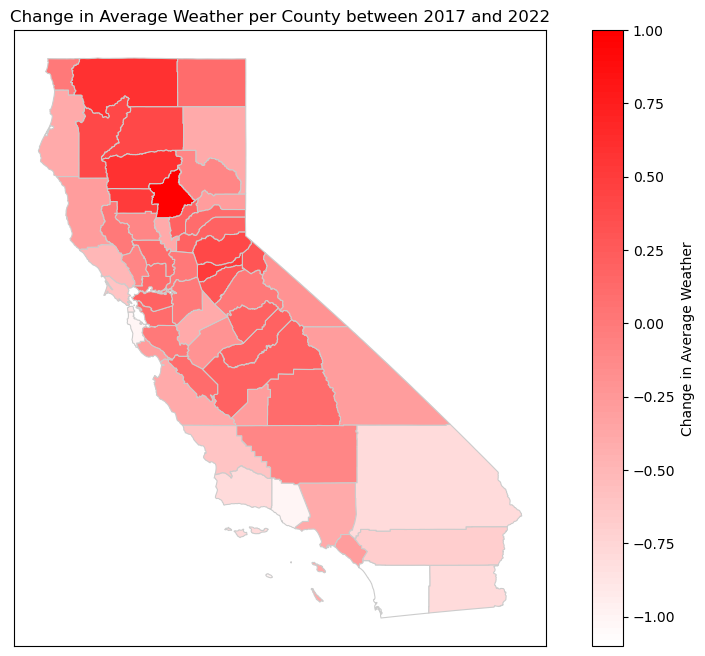

In [23]:

# Load the weather data for California counties
weather_df = pd.read_csv('resourcesJohn/20172022averageweather.csv')

# Clean the 'Name' field to remove " County" from county names
weather_df['Name'] = weather_df['Name'].str.replace(' County', '')

# Set the 'Year' column as a datetime type
weather_df['Year'] = pd.to_datetime(weather_df['Year'], format='%Y')

# Step 1: Calculate the average weather value for each county and year
avg_weather_by_county = weather_df.pivot_table(index='Name', columns=weather_df['Year'].dt.year, values='Value', aggfunc='mean')

# Calculate the change in average weather per county between 2017 and 2022
avg_weather_change_df = avg_weather_by_county.copy()
avg_weather_change_df['Change'] = avg_weather_change_df[2022] - avg_weather_change_df[2017]

# Merge average weather data with California county boundaries data
california_counties = gpd.read_file('california_counties.geojson')
merged_df = pd.merge(california_counties, avg_weather_change_df, left_on='name', right_on='Name', how='left')

# Create the figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define a custom colormap that ranges from white to red
colors = ['white', 'red']
cmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', colors, N=100)

# Plot the choropleth map using the 'Change' field for coloring
vmin = avg_weather_change_df['Change'].min()
vmax = avg_weather_change_df['Change'].max()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
im = merged_df.plot(column='Change', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Change in Average Weather')

# Set the title for the plot
plt.title('Change in Average Weather per County between 2017 and 2022')

# Remove x and y axis ticks and labels for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

/var/folders/yv/0ytq2z913n1bk1y0rnsc187m0000gn/T/ipykernel_46101/3581327350.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Oranges')


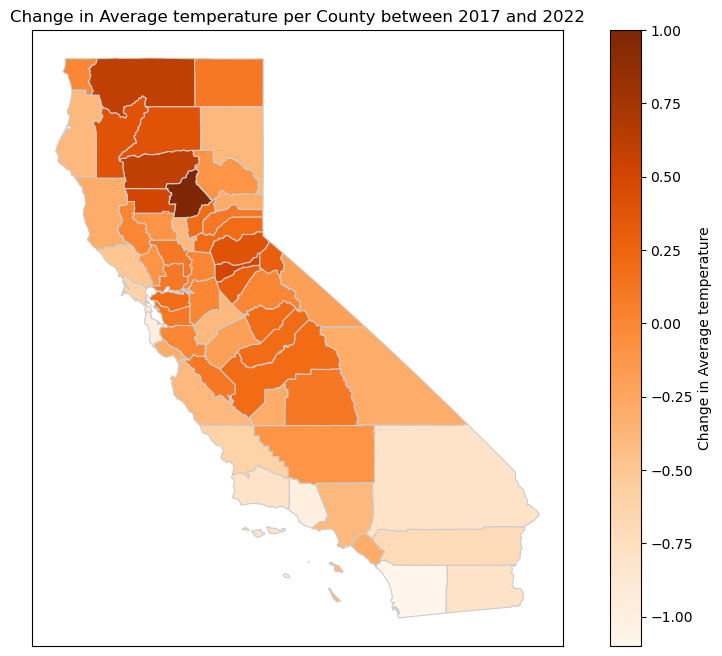


Counties ordered by the largest change in average temperature between 2017 and 2022:
Year           County  Change
0               Butte     1.0
1              Tehama     0.6
2            Siskiyou     0.6
3              Amador     0.5
4               Glenn     0.5
5           El Dorado     0.4
6              Shasta     0.4
7             Trinity     0.4
8              Alpine     0.3
9           Calaveras     0.3
10               Yuba     0.2
11             Placer     0.2
12             Fresno     0.2
13             Madera     0.2
14       Contra Costa     0.2
15           Mariposa     0.2
16             Tulare     0.1
17               Yolo     0.1
18            Alameda     0.1
19             Solano     0.1
20         San Benito     0.1
21              Modoc     0.1
22             Nevada     0.1
23        San Joaquin     0.0
24           Tuolumne     0.0
25         Sacramento     0.0
26          Del Norte     0.0
27        Santa Clara     0.0
28               Lake     0.0
29            

In [20]:

# Load the weather data for California counties
weather_df = pd.read_csv('resourcesJohn/20172022averageweather.csv')

# Clean the 'Name' field in the weather_df to remove " County" from county names
weather_df['Name'] = weather_df['Name'].str.replace(' County', '')

# Create a pivot table to get average weather data for each county in each year
avg_weather_by_county = weather_df.pivot_table(index='Name', columns='Year', values='Value', aggfunc='mean')

# Calculate the change in average weather per county between 2017 and 2022
avg_weather_by_county['Change'] = avg_weather_by_county[2022] - avg_weather_by_county[2017]

# Sort the data based on the largest change
avg_weather_change_df_sorted = avg_weather_by_county.sort_values(by='Change', ascending=False)

# Reset the index and rename the columns
avg_weather_change_df_sorted.reset_index(inplace=True)
avg_weather_change_df_sorted = avg_weather_change_df_sorted.rename(columns={'Name': 'County'})

# Load the GeoJSON file for California counties
california_counties = gpd.read_file('california_counties.geojson')

# Merge county boundaries data with the sorted weather change data
merged_df = pd.merge(california_counties, avg_weather_change_df_sorted, left_on='name', right_on='County', how='left')

# Create the figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define the 'Oranges' colormap
cmap = plt.cm.get_cmap('Oranges')

# Plot the choropleth map using the 'Change' field for coloring
vmin = avg_weather_change_df_sorted['Change'].min()
vmax = avg_weather_change_df_sorted['Change'].max()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
im = merged_df.plot(column='Change', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Change in Average temperature')

# Set the title for the plot
plt.title('Change in Average temperature per County between 2017 and 2022')

# Remove x and y axis ticks and labels for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

# Display the entire table for "Counties ordered by the largest change in average weather between 2017 and 2022"
pd.set_option('display.max_rows', None)
print("\nCounties ordered by the largest change in average temperature between 2017 and 2022:")
print(avg_weather_change_df_sorted[['County', 'Change']].reset_index(drop=True))

Correlation between change in homelessness and change in average temperature: -0.2597341431381372


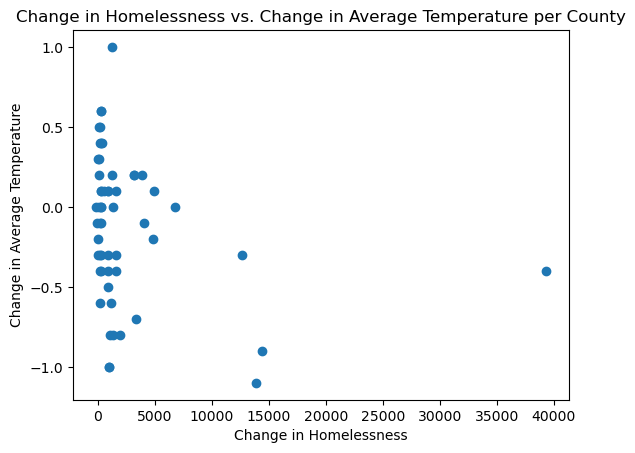

In [24]:
# Merge the dataframes on the "County" column
merged_data = pd.merge(homelessness_change_df_sorted, avg_weather_change_df_sorted, on='County', how='inner')

# Calculate the correlation between the two variables
correlation = merged_data['Change_x'].corr(merged_data['Change_y'])
print("Correlation between change in homelessness and change in average temperature:", correlation)

# Create a scatter plot to visualize the relationship
plt.scatter(merged_data['Change_x'], merged_data['Change_y'])
plt.xlabel('Change in Homelessness')
plt.ylabel('Change in Average Temperature')
plt.title('Change in Homelessness vs. Change in Average Temperature per County')
plt.show()

In [25]:
# Create the new dataframe for plotting
avg_weather_change_df_sorted.reset_index(inplace=True)
avg_weather_change_df_sorted = avg_weather_change_df_sorted[['County', 'Change', 2017, 2022]]
avg_weather_change_df_sorted.rename(columns={2017: 'Average Weather 2017', 2022: 'Average Weather 2022'}, inplace=True)

# Display the entire table
pd.set_option('display.max_rows', None)
print("\nCounties ordered by the largest change in average weather between 2017 and 2022:")
print(avg_weather_change_df_sorted.reset_index(drop=True))


Counties ordered by the largest change in average weather between 2017 and 2022:
Year           County  Change  Average Weather 2017  Average Weather 2022
0               Butte     1.0                  61.1                  62.1
1              Tehama     0.6                  60.1                  60.7
2            Siskiyou     0.6                  50.0                  50.6
3              Amador     0.5                  59.5                  60.0
4               Glenn     0.5                  61.4                  61.9
5           El Dorado     0.4                  55.3                  55.7
6              Shasta     0.4                  56.6                  57.0
7             Trinity     0.4                  53.7                  54.1
8              Alpine     0.3                  45.4                  45.7
9           Calaveras     0.3                  60.0                  60.3
10               Yuba     0.2                  62.3                  62.5
11             Placer     0.2 